In [9]:
# General
import numpy as np
import pandas as pd
import os

# For loading data and feature engineering
from feature_25 import DataLoader, MergedDataLoader

# For data prep and pre-processing
from jumpmodels.utils import filter_date_range 
from jumpmodels.preprocess import StandardScalerPD, DataClipperStd
from sklearn.preprocessing import StandardScaler

# For model fit and prediction
from joblib import Parallel, delayed # allows parallel grid search on all 4 cores
from jumpmodels.sparse_jump import SparseJumpModel

# For plotting
from jumpmodels.plot import plot_regimes_and_cumret, plot_cumret
import matplotlib.pyplot as plt

In [10]:
# import importlib
# import feature_25 
# importlib.reload(feature_25)


In [11]:
# ============ 2) The Cross-Validation Function ============

def rolling_time_series_cv_sjm_long_short(
    lam,
    kappa,
    X,
    factor_returns,
    market_returns,
    n_splits=5,
    initial_train_size=5*252,
    val_size=252,
    cost_per_100pct=0.0005,
    annual_threshold=0.05
):
    """
    Your original rolling expanding-window CV function. For each fold, it clips/scales,
    fits a SparseJumpModel, does day-lag logic, and returns a single Sharpe.
    We then average across folds.
    """
    n_samples = len(X)
    max_folds = (n_samples - initial_train_size) // val_size
    actual_folds = min(n_splits, max_folds)

    max_feats = int(kappa**2)
    sharpe_scores = []

    def position_from_expected_return(ann_ret, threshold=annual_threshold):
        if ann_ret > threshold: 
            return 1.0
        elif ann_ret < -threshold: 
            return -1.0
        else: 
            return ann_ret / threshold

    start_of_val = initial_train_size

    for fold_i in range(actual_folds):
        train_end = start_of_val
        val_end = start_of_val + val_size
        if val_end > n_samples:
            val_end = n_samples

        # 1) Raw slices
        X_train_cv_raw = X.iloc[:train_end]
        y_train_cv     = factor_returns.iloc[:train_end]
        m_train_cv     = market_returns.iloc[:train_end]

        X_val_cv_raw   = X.iloc[train_end:val_end]
        y_val_cv       = factor_returns.iloc[train_end:val_end]
        m_val_cv       = market_returns.iloc[train_end:val_end]

        print(f"Fold {fold_i+1}: Train=[0:{train_end}], Val=[{train_end}:{val_end}]")

        # 2) Clipper/scaler on training portion only
        clipper_fold = DataClipperStd(mul=3.)
        X_train_cv_raw_clipped = clipper_fold.fit_transform(X_train_cv_raw)
        X_val_cv_raw_clipped   = clipper_fold.transform(X_val_cv_raw)

        scaler_fold = StandardScaler()
        X_train_cv = scaler_fold.fit_transform(X_train_cv_raw_clipped)
        X_val_cv   = scaler_fold.transform(X_val_cv_raw_clipped)

        # 3) Fit SJM
        model = SparseJumpModel(
            n_components=2,
            max_feats=max_feats,
            jump_penalty=lam,
            cont=False,
            max_iter=30
        )
        model.fit(X_train_cv, y_train_cv, sort_by="cumret")

        # 4) Regime inference on validation
        val_states = model.predict_online(X_val_cv)

        # 5) Evaluate strategy: day-lag logic
        val_active_ret = y_val_cv - m_val_cv
        strategy_ret = np.zeros(len(val_states))
        prev_position = 0.0

        # Compute expected return per regime from training
        state_avg_daily_ret = model.ret_
        avg_mkt_ret = m_train_cv.mean()
        state_to_expected = {
            st: (state_avg_daily_ret[st] - avg_mkt_ret)*252
            for st in range(len(state_avg_daily_ret))
        }

        for t in range(len(val_states)):
            daily_pnl = prev_position * val_active_ret.iloc[t]
            st = val_states[t]
            new_position = position_from_expected_return(state_to_expected.get(st,0.0))
            turnover = abs(new_position - prev_position)*2.0
            cost = turnover * cost_per_100pct
            strategy_ret[t] = daily_pnl - cost
            prev_position = new_position

        avg_ret = np.mean(strategy_ret)
        std_ret = np.std(strategy_ret, ddof=1)
        val_sharpe = 0.0 if std_ret==0 else (avg_ret/std_ret)*np.sqrt(252)

        sharpe_scores.append(val_sharpe)
        start_of_val += val_size  # expand window for next fold

    return np.mean(sharpe_scores)


Running SJM cross-validation for factor = IWF
Training starts: 2002-08-28 00:00:00 ends: 2021-12-31 00:00:00
Testing starts: 2022-01-03 00:00:00 ends: 2025-02-24 00:00:00
[IWF] Best Jump Penalty (λ): 66.17434558908558
[IWF] Best Max Features (κ²): 4
[IWF] Sharpe with best hyperparams: 0.26554761785687564


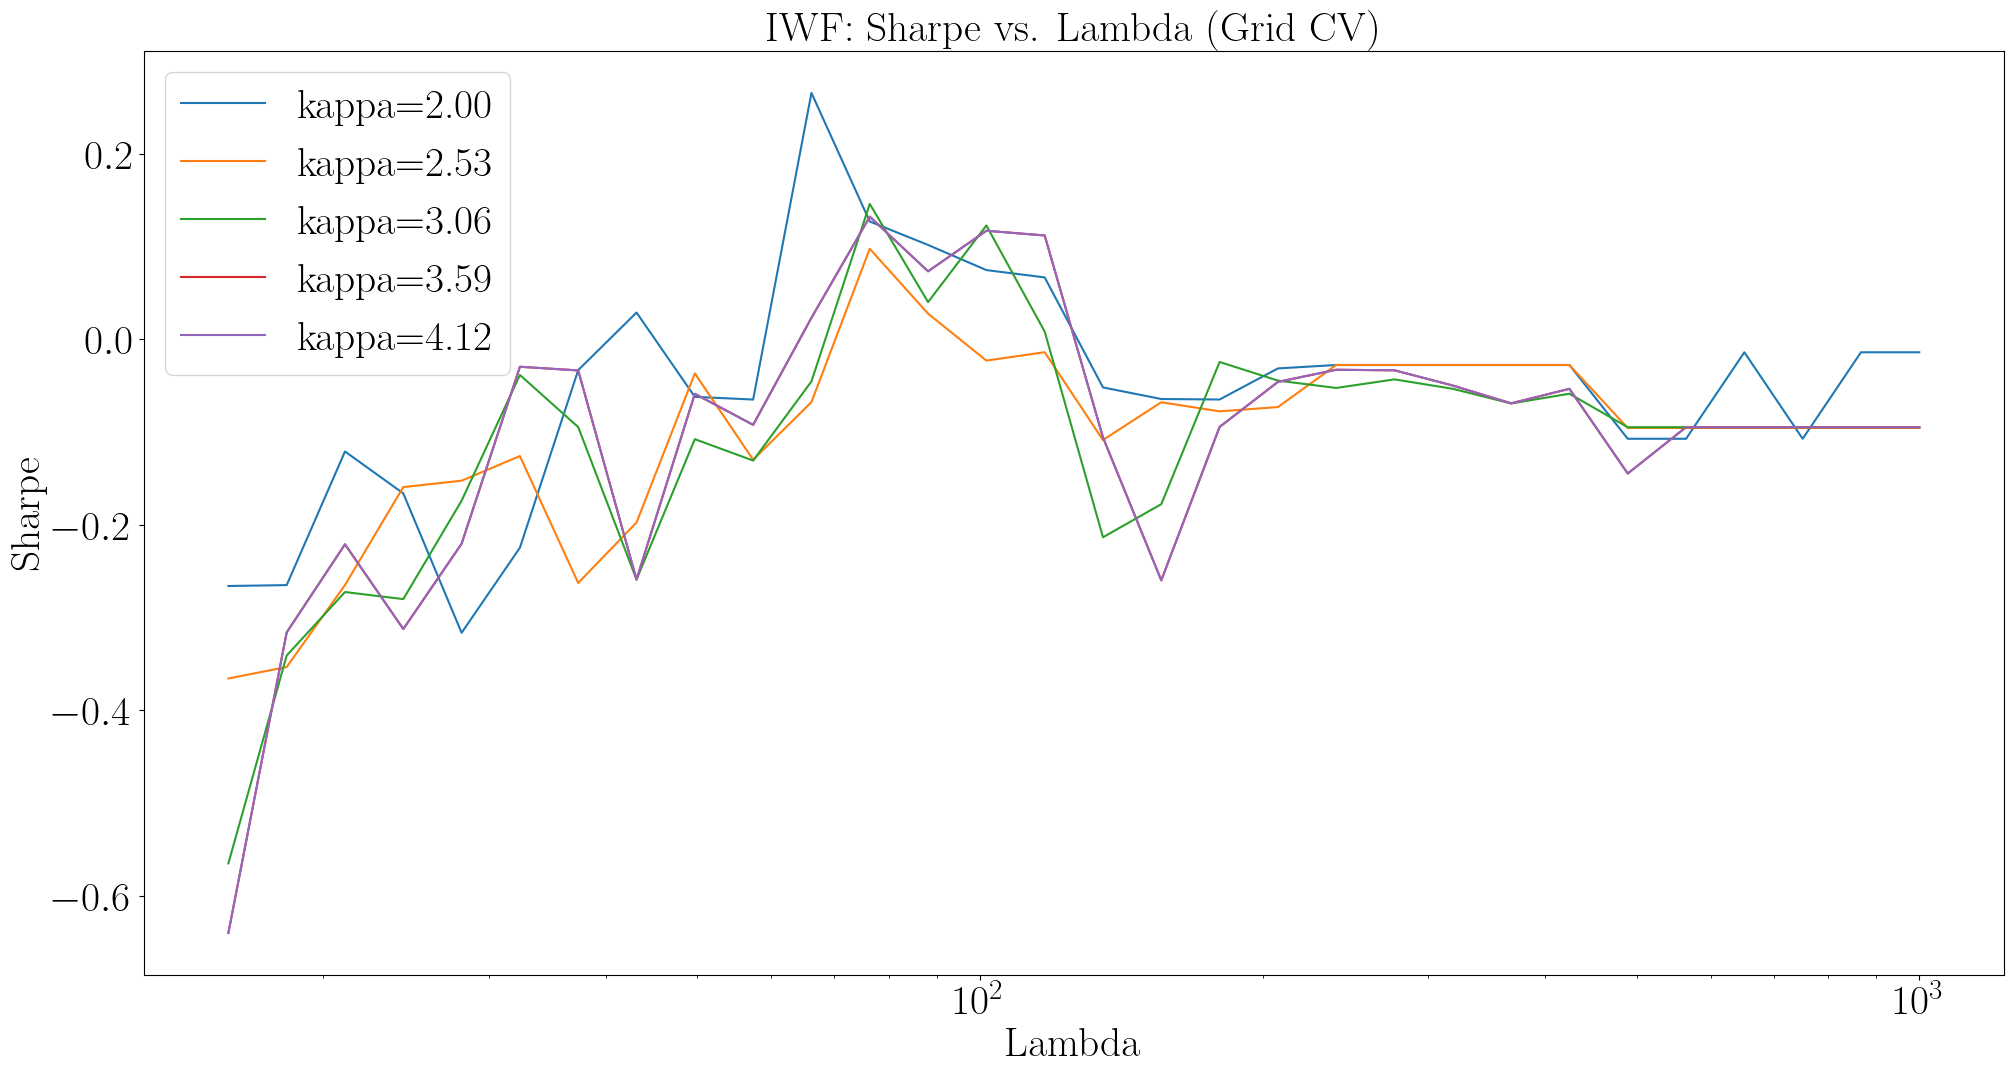

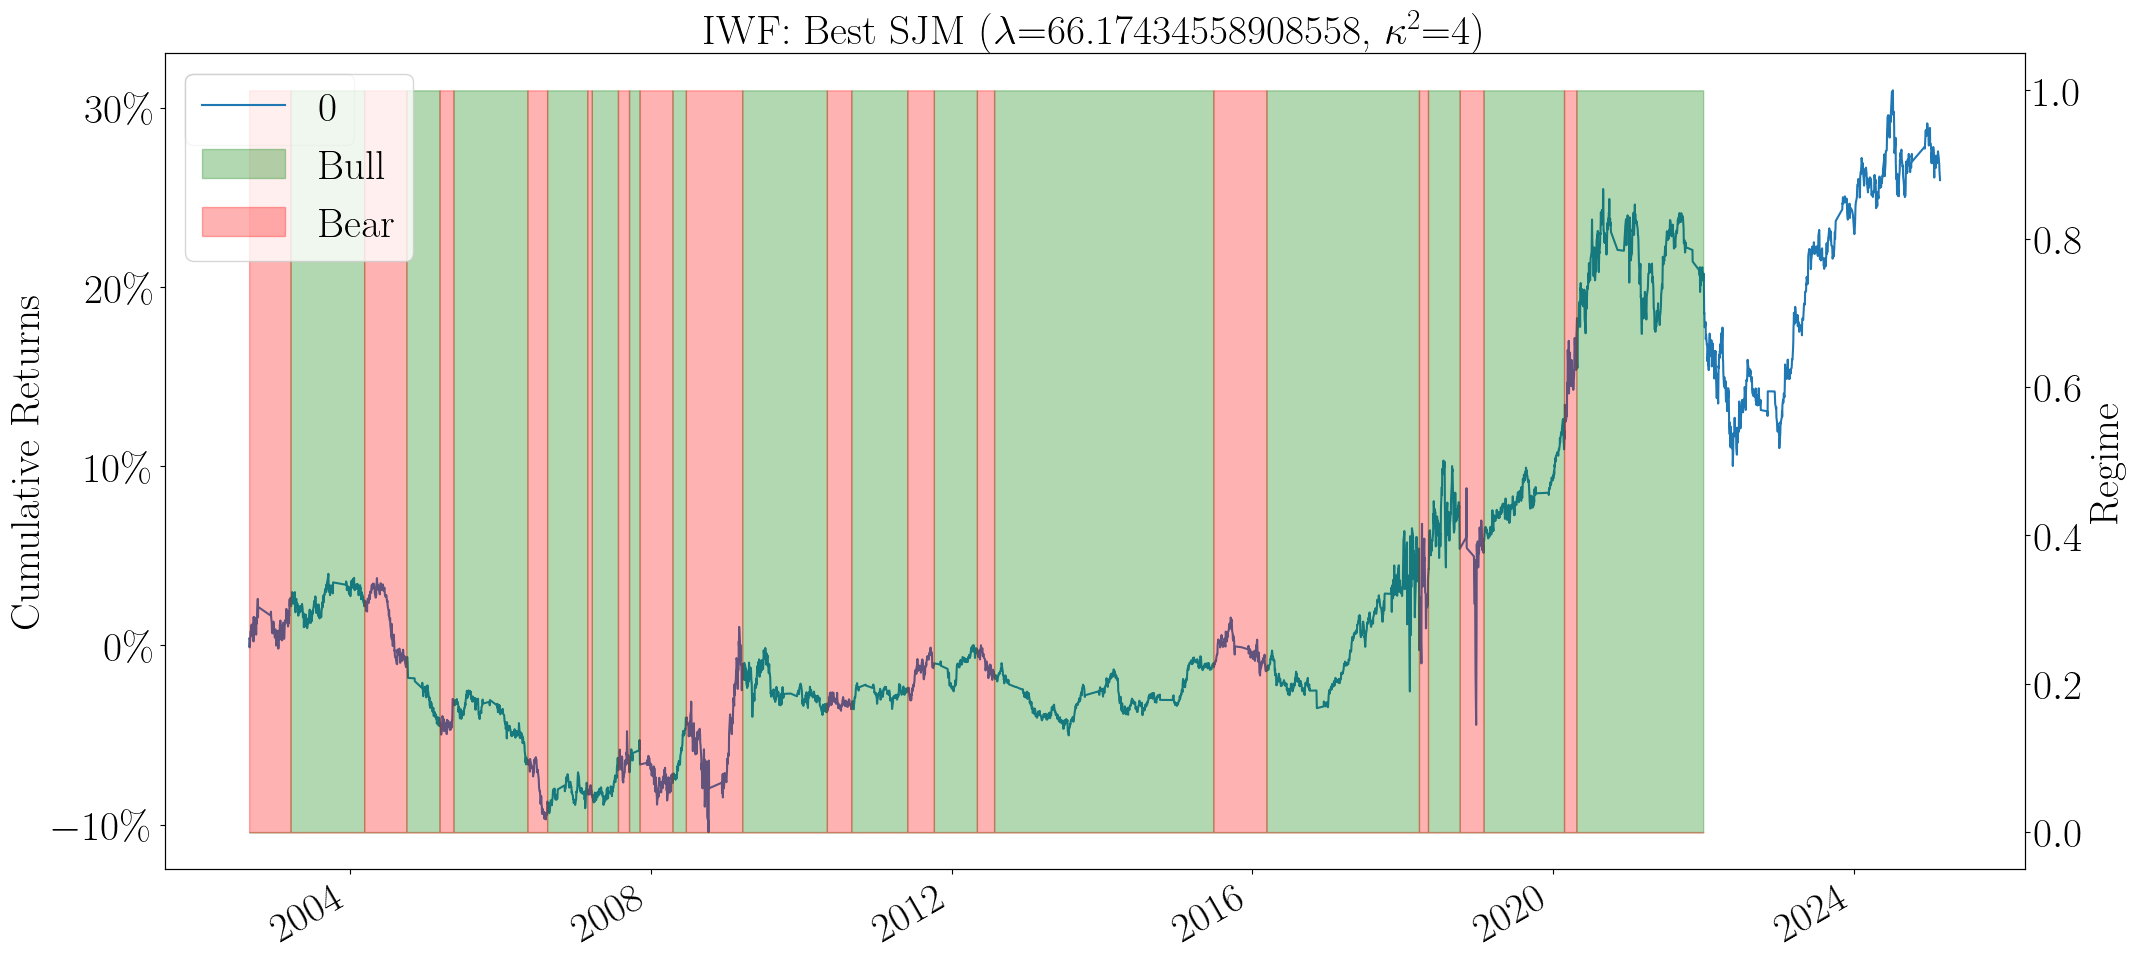


Running SJM cross-validation for factor = MTUM
Training starts: 2002-08-28 00:00:00 ends: 2021-12-31 00:00:00
Testing starts: 2022-01-03 00:00:00 ends: 2025-02-24 00:00:00
[MTUM] Best Jump Penalty (λ): 239.5026619987486
[MTUM] Best Max Features (κ²): 4
[MTUM] Sharpe with best hyperparams: 0.5651212740657675


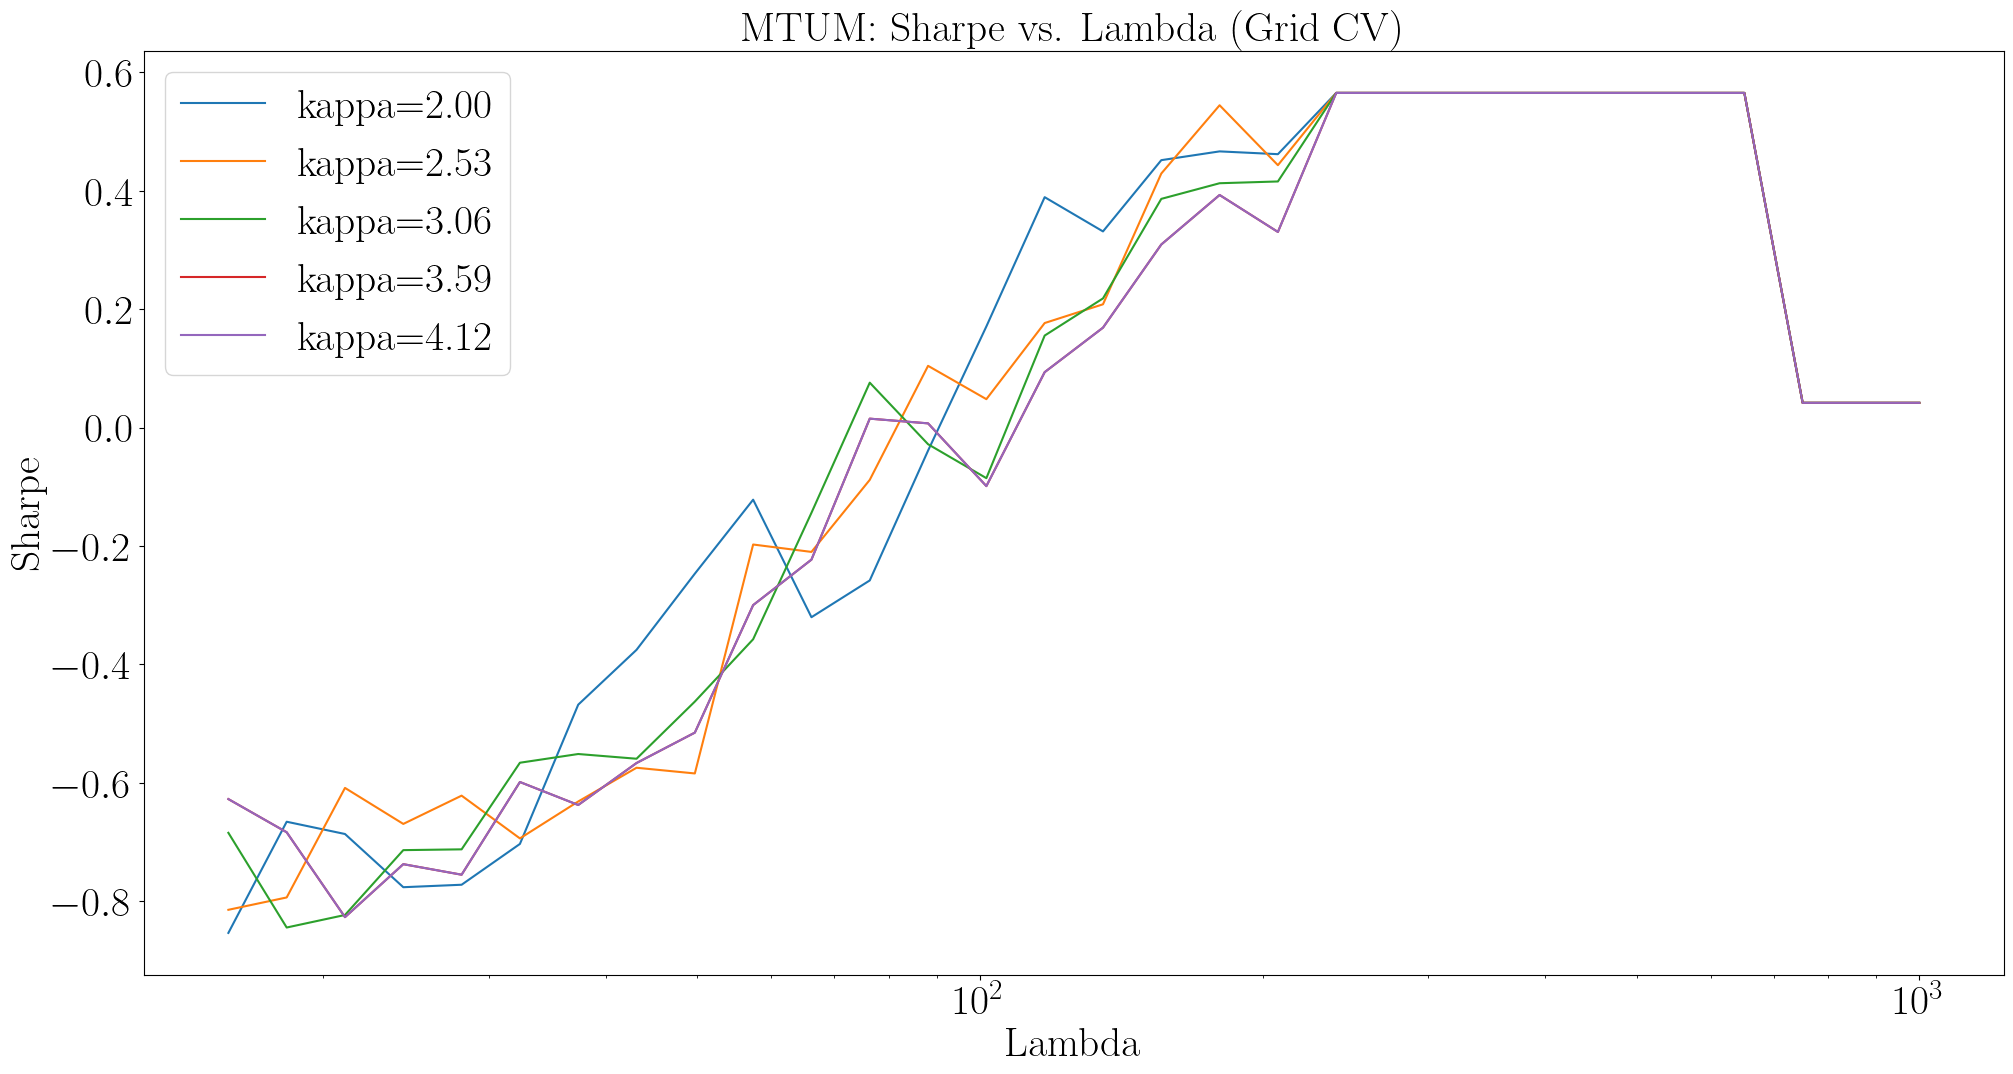

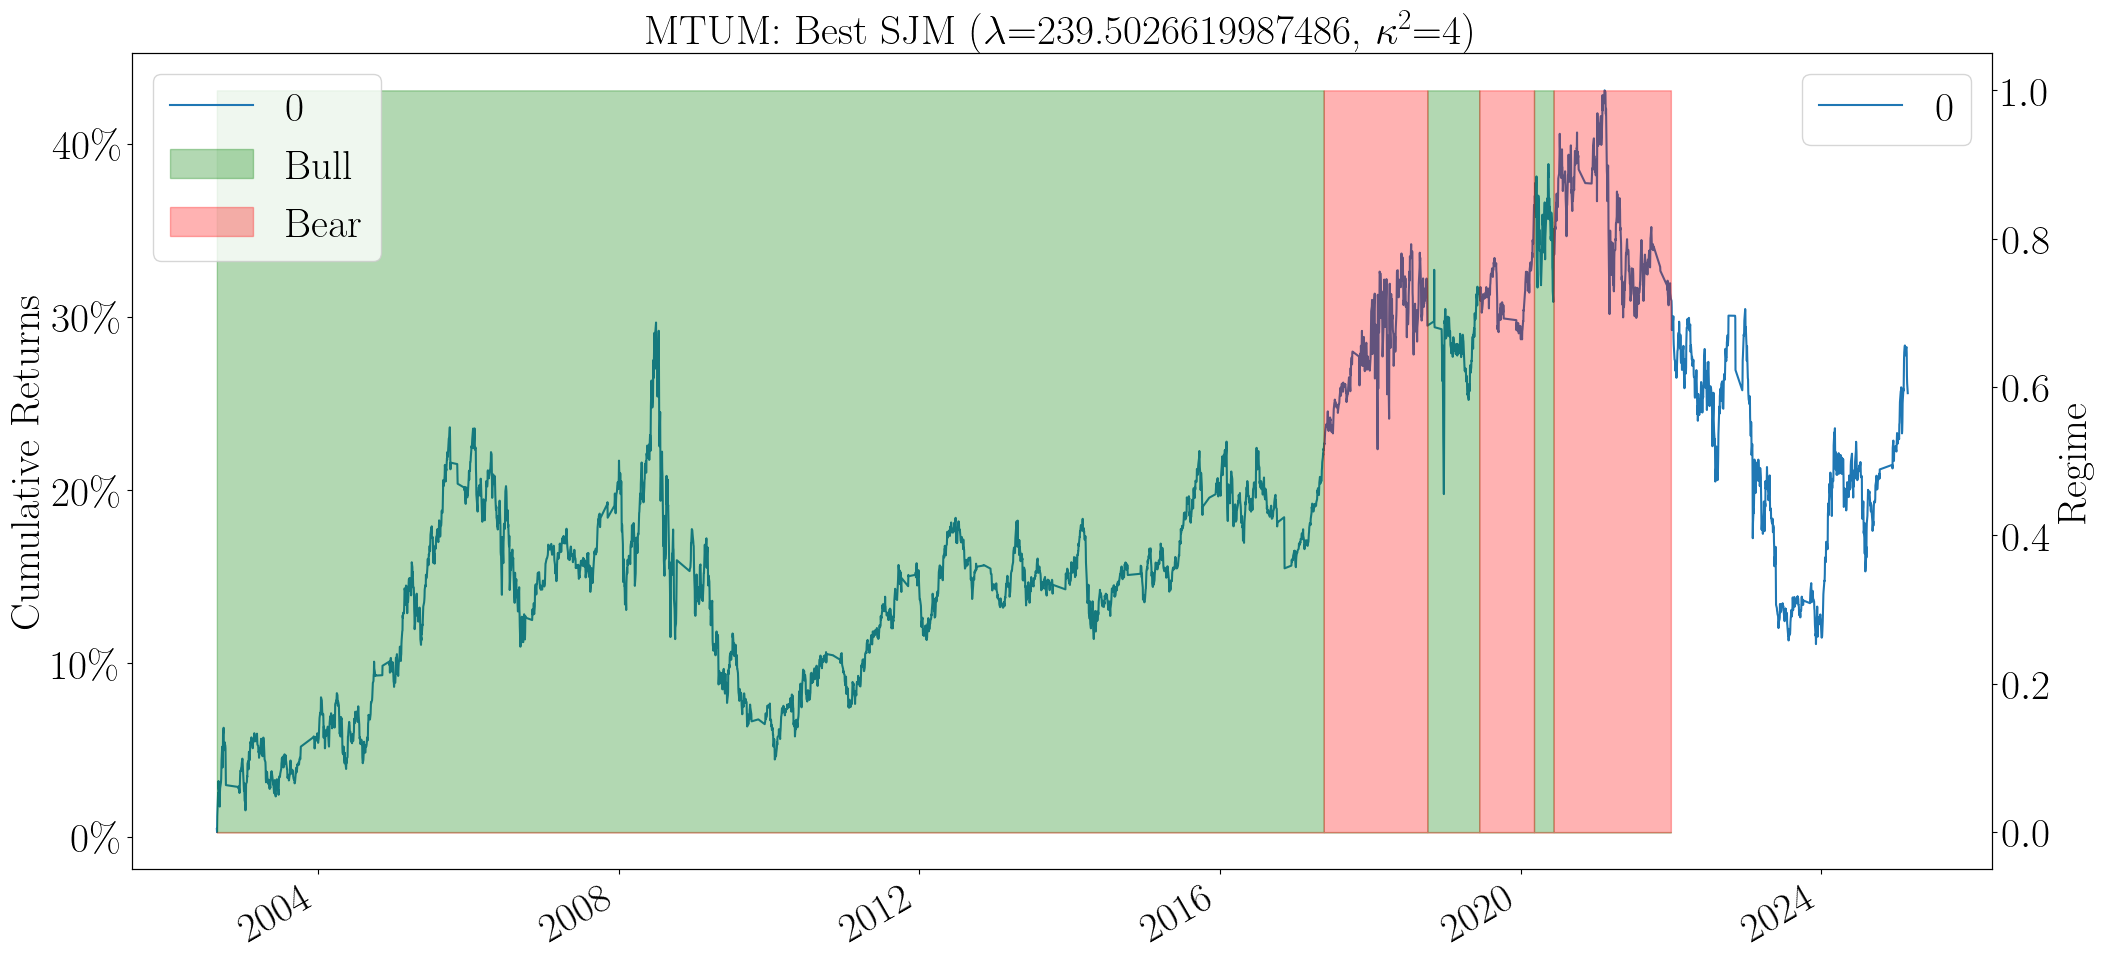


Running SJM cross-validation for factor = QUAL
Training starts: 2002-08-28 00:00:00 ends: 2021-12-31 00:00:00
Testing starts: 2022-01-03 00:00:00 ends: 2025-02-24 00:00:00
[QUAL] Best Jump Penalty (λ): 66.17434558908558
[QUAL] Best Max Features (κ²): 6
[QUAL] Sharpe with best hyperparams: 0.25383859429267075


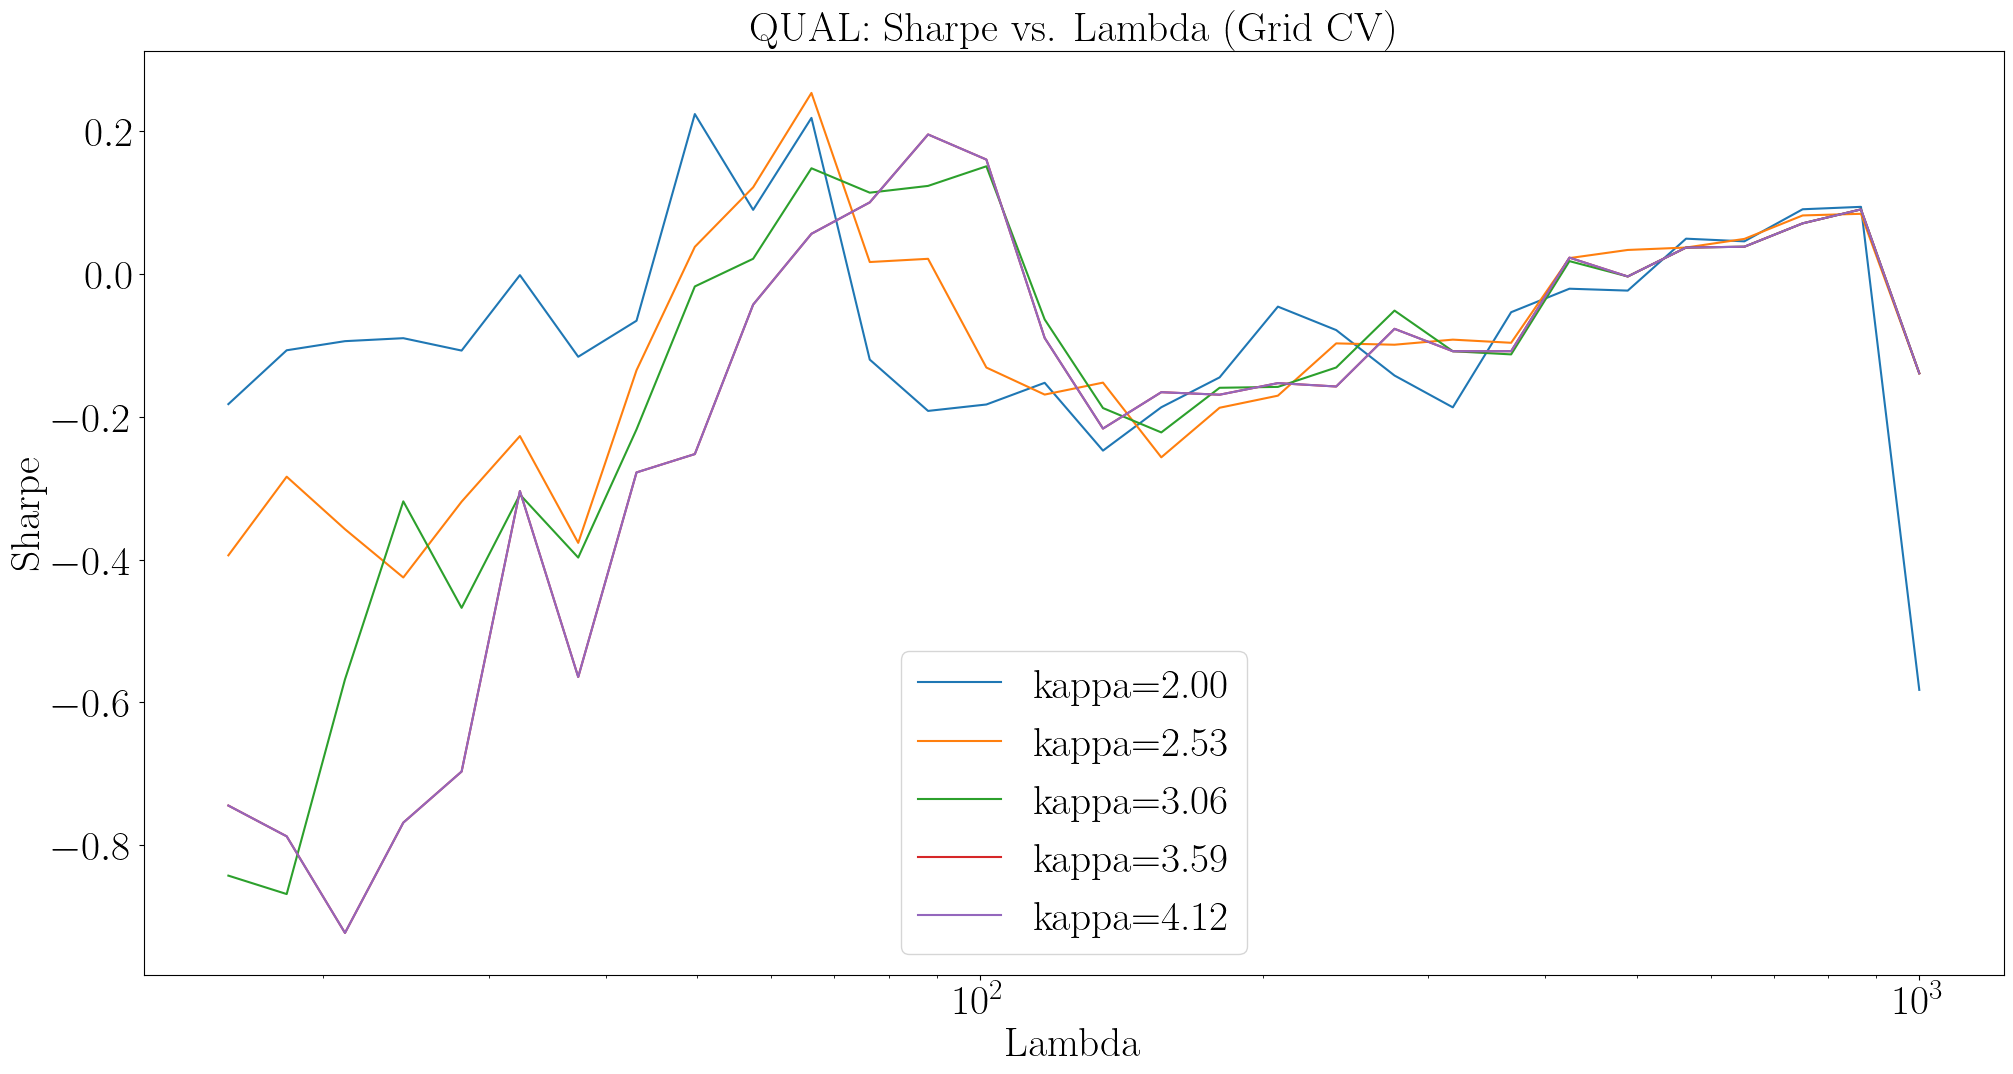

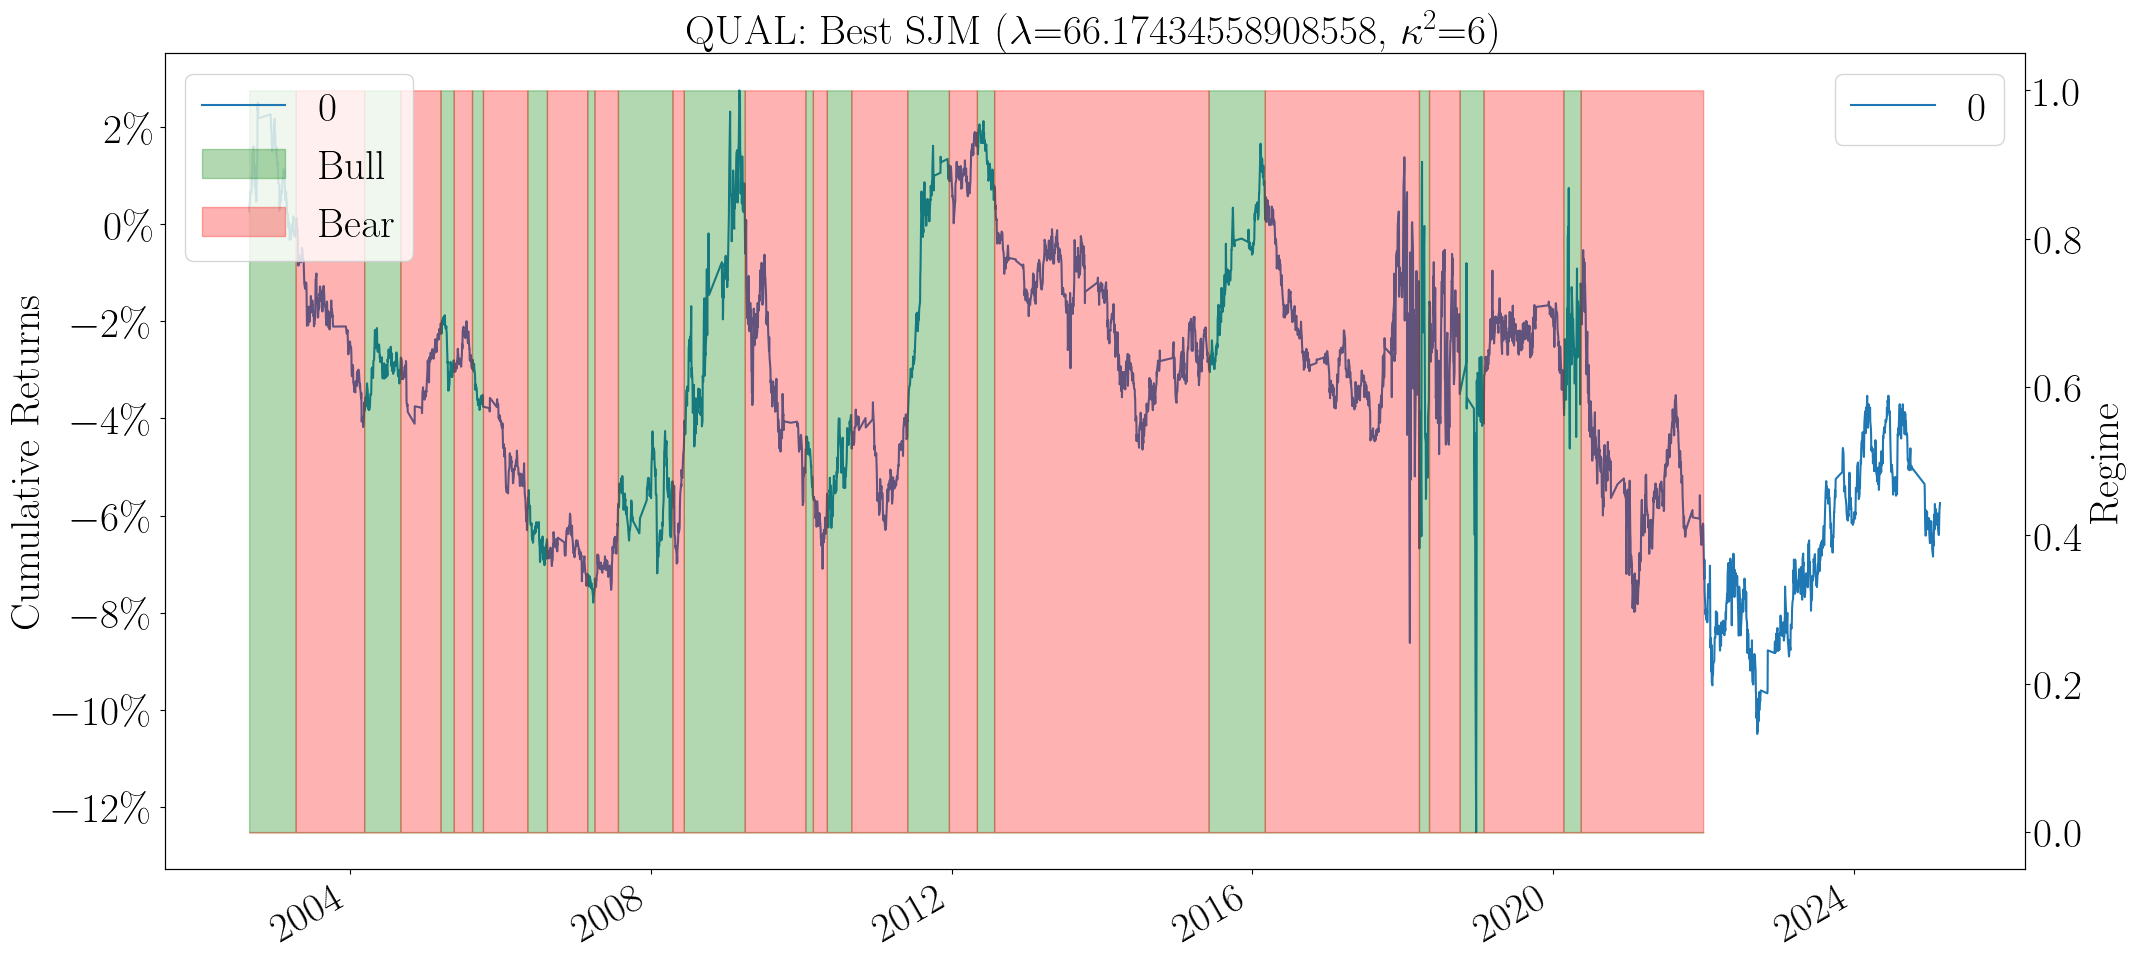


Running SJM cross-validation for factor = SIZE
Training starts: 2002-08-28 00:00:00 ends: 2021-12-31 00:00:00
Testing starts: 2022-01-03 00:00:00 ends: 2025-02-24 00:00:00
[SIZE] Best Jump Penalty (λ): 49.72235891449993
[SIZE] Best Max Features (κ²): 12
[SIZE] Sharpe with best hyperparams: 0.583180977807284


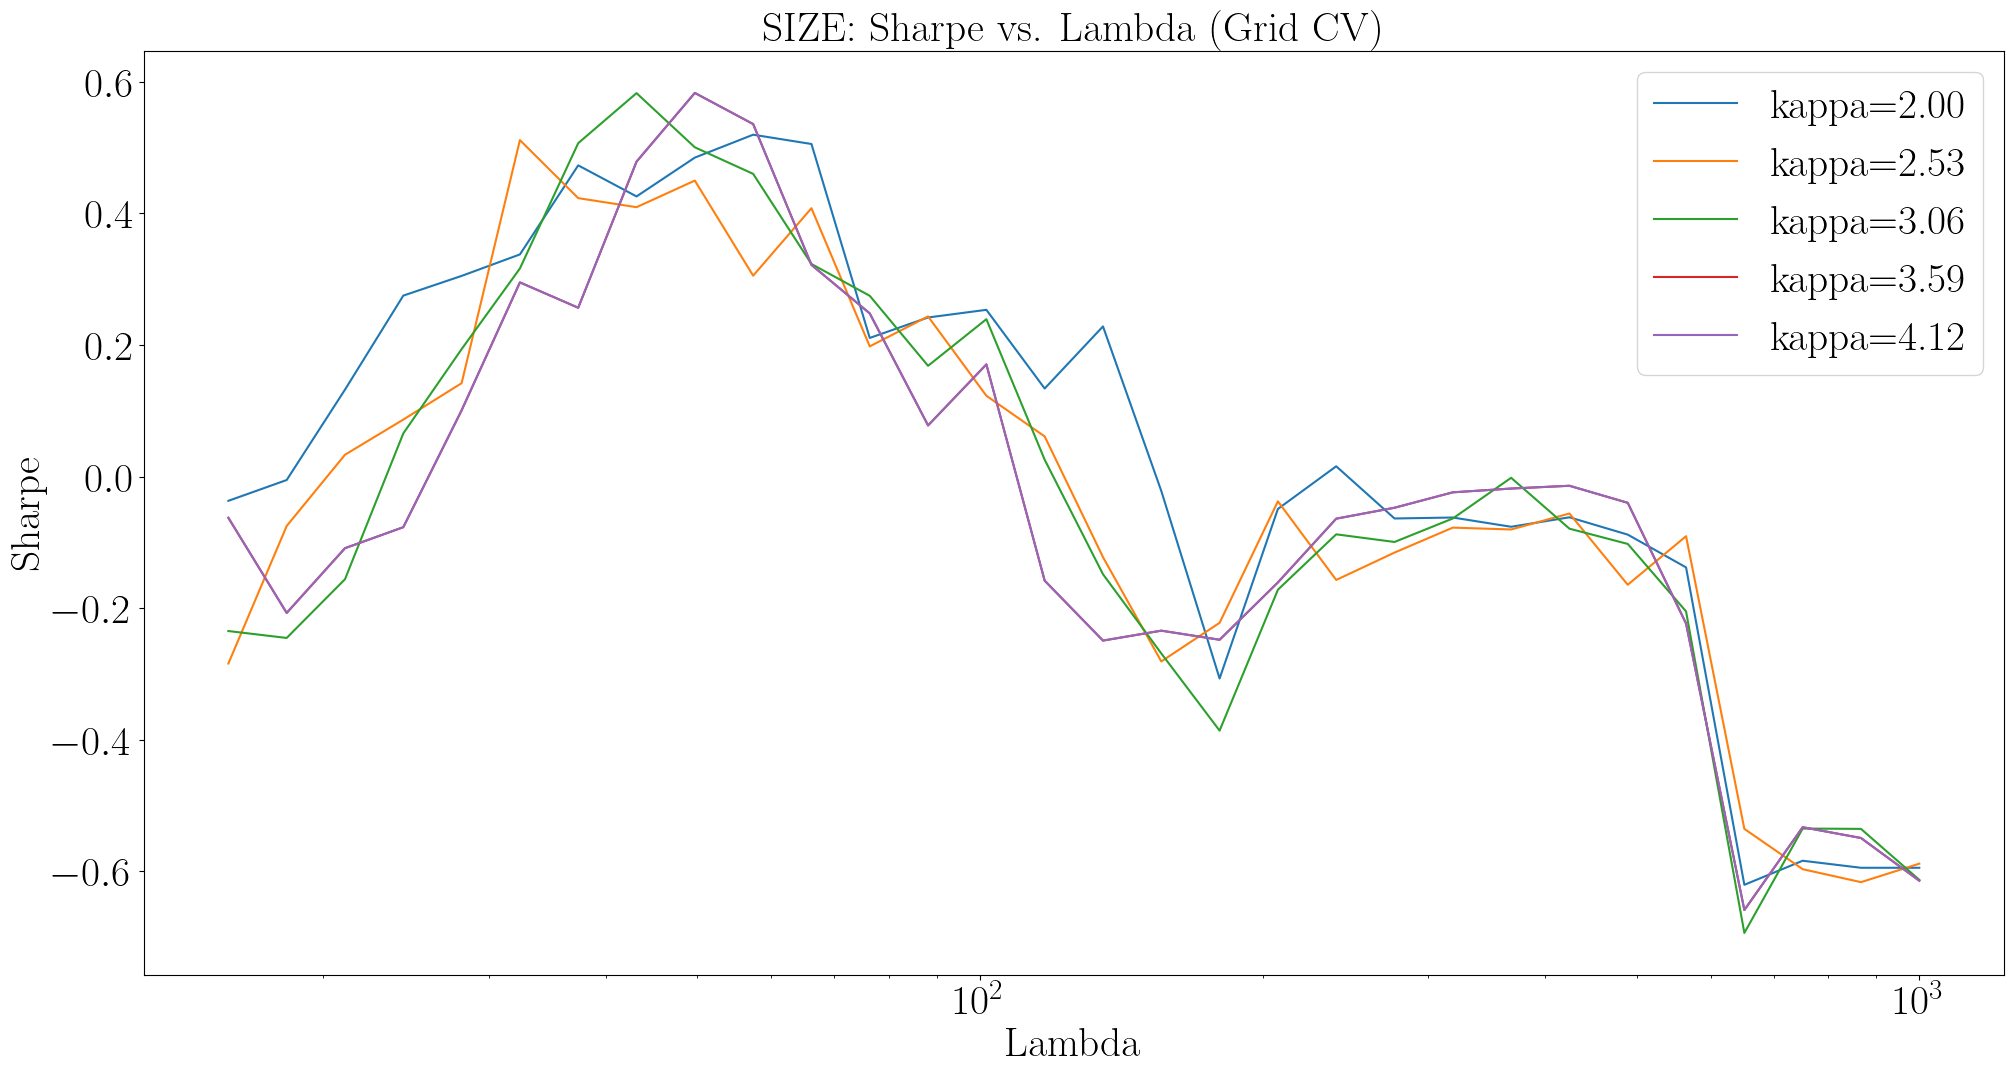

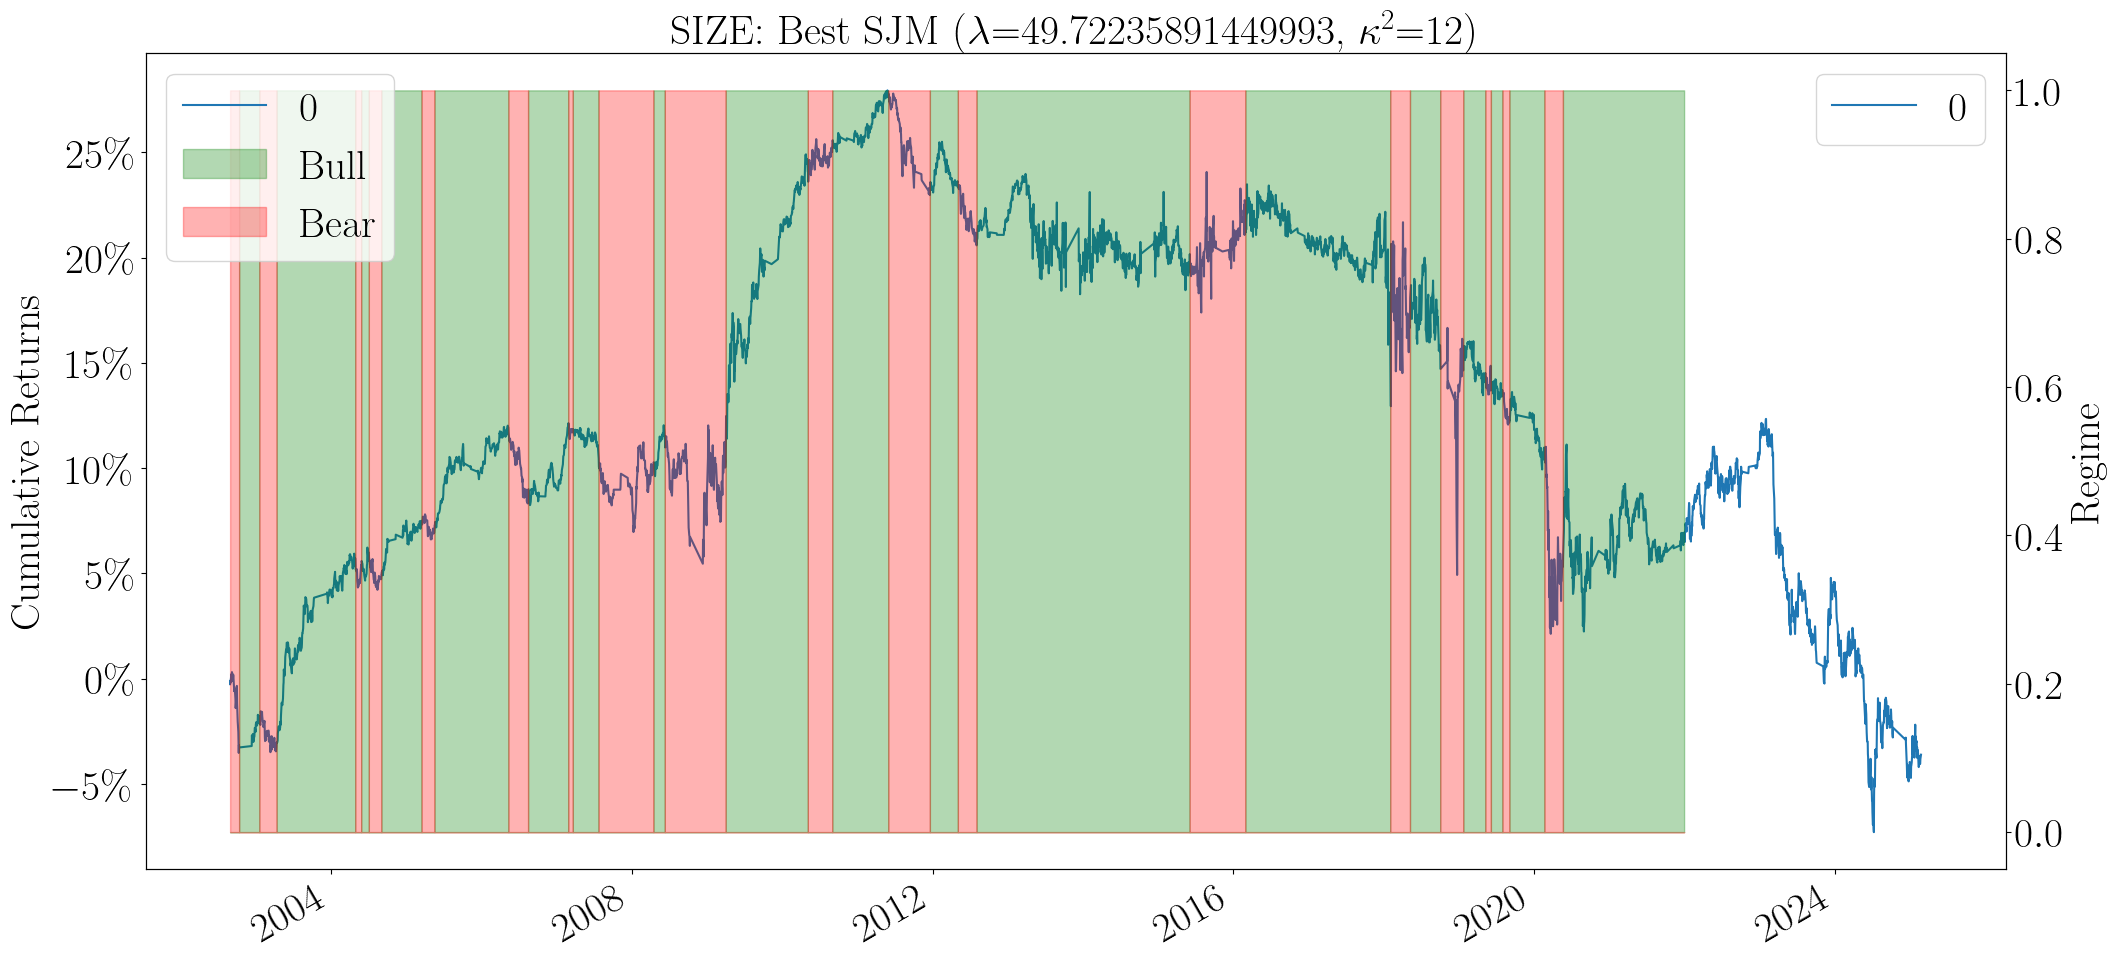


Running SJM cross-validation for factor = USMV
Training starts: 2002-08-28 00:00:00 ends: 2021-12-31 00:00:00
Testing starts: 2022-01-03 00:00:00 ends: 2025-02-24 00:00:00
[USMV] Best Jump Penalty (λ): 751.3842180360134
[USMV] Best Max Features (κ²): 6
[USMV] Sharpe with best hyperparams: 0.17376469442761117


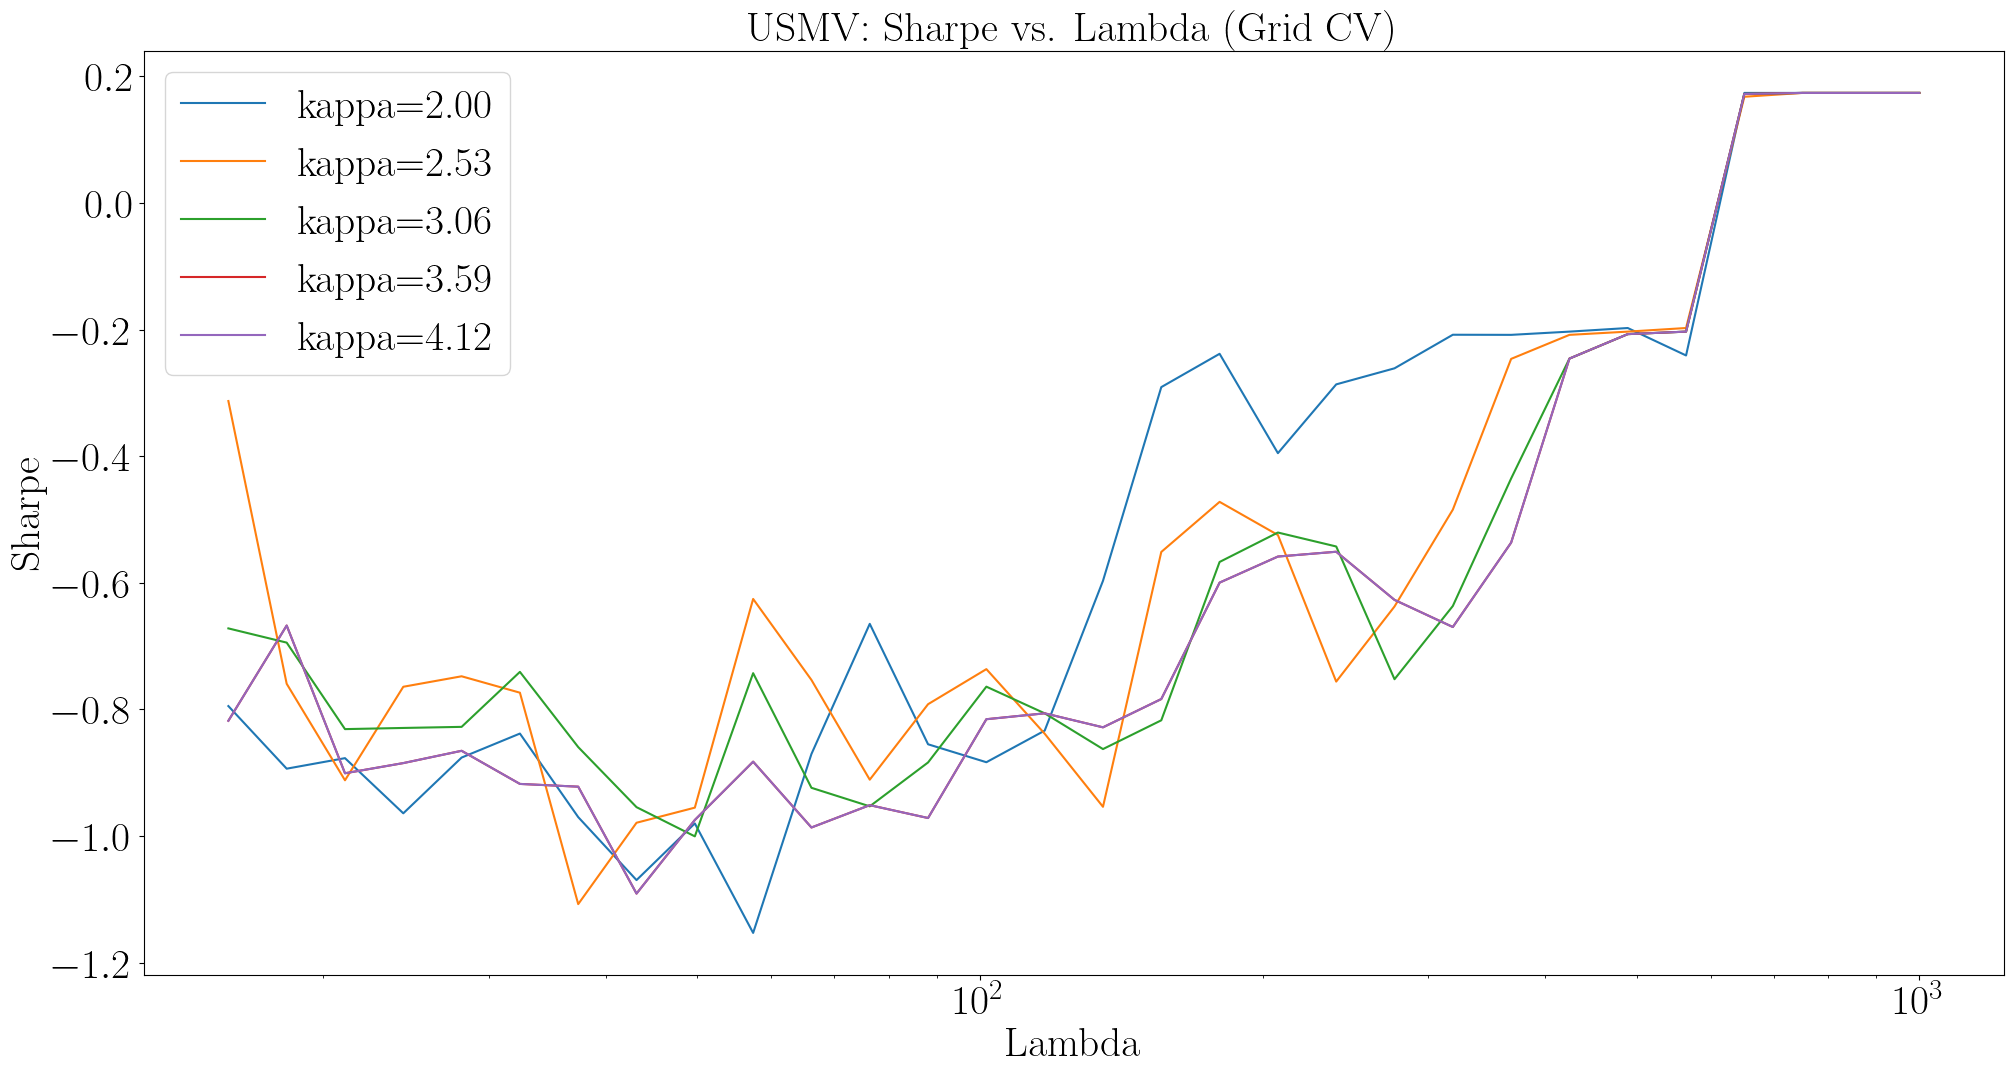

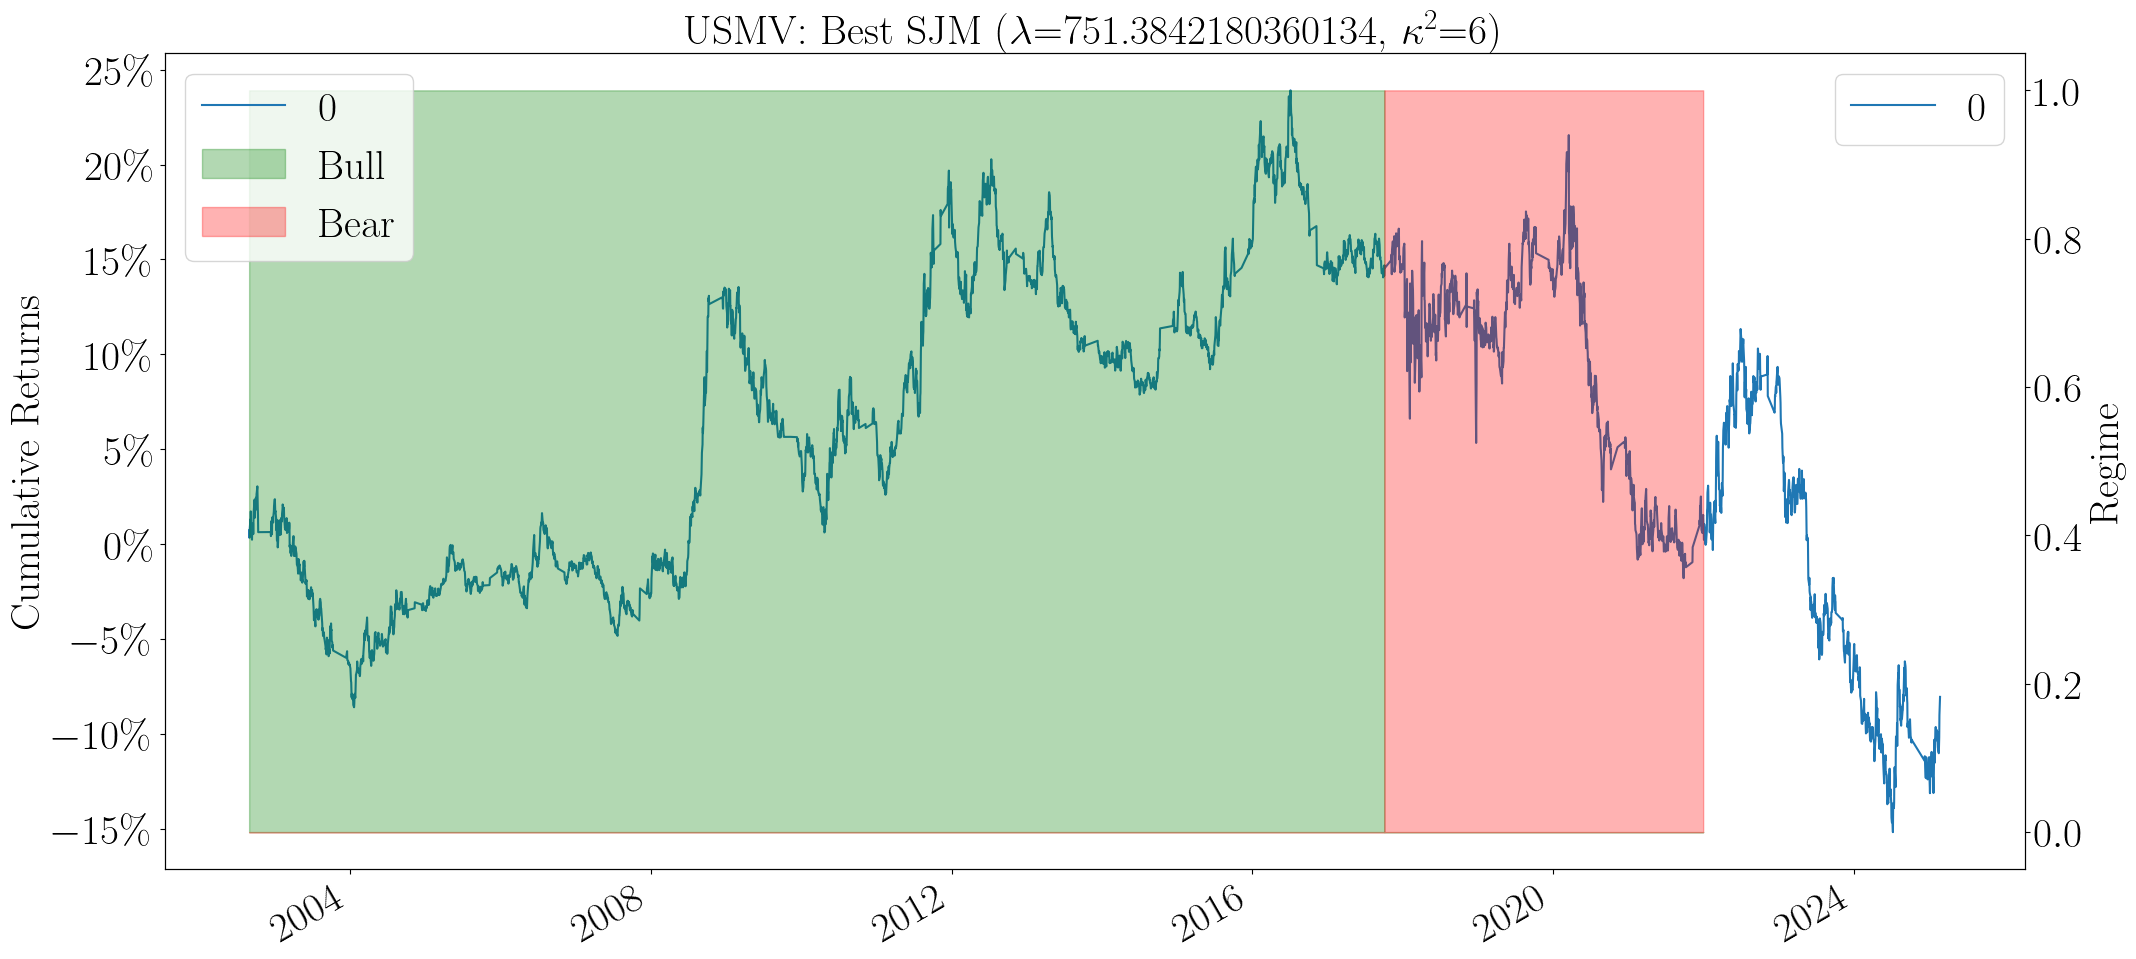


Running SJM cross-validation for factor = VLUE
Training starts: 2002-08-28 00:00:00 ends: 2021-12-31 00:00:00
Testing starts: 2022-01-03 00:00:00 ends: 2025-02-24 00:00:00
[VLUE] Best Jump Penalty (λ): 57.36152510448679
[VLUE] Best Max Features (κ²): 4
[VLUE] Sharpe with best hyperparams: 1.390909270041218


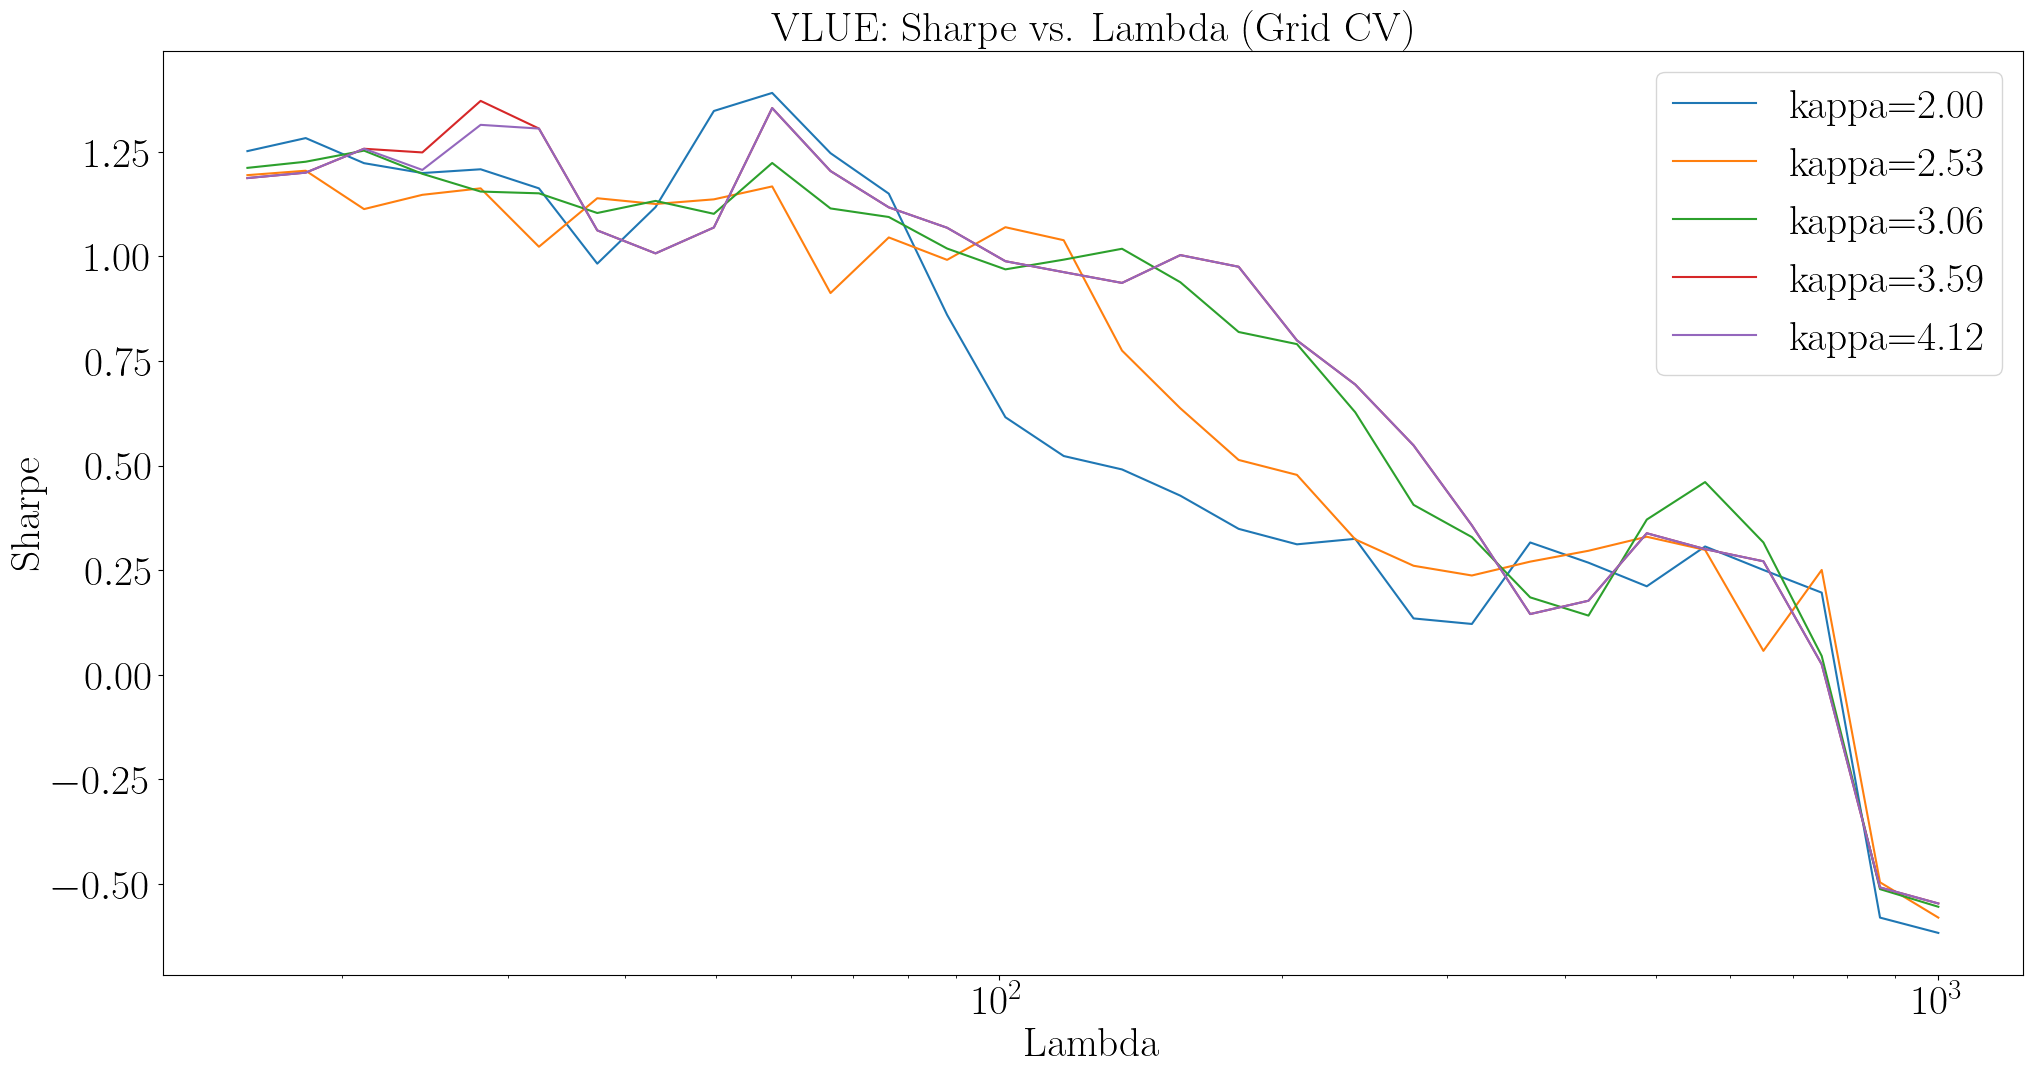

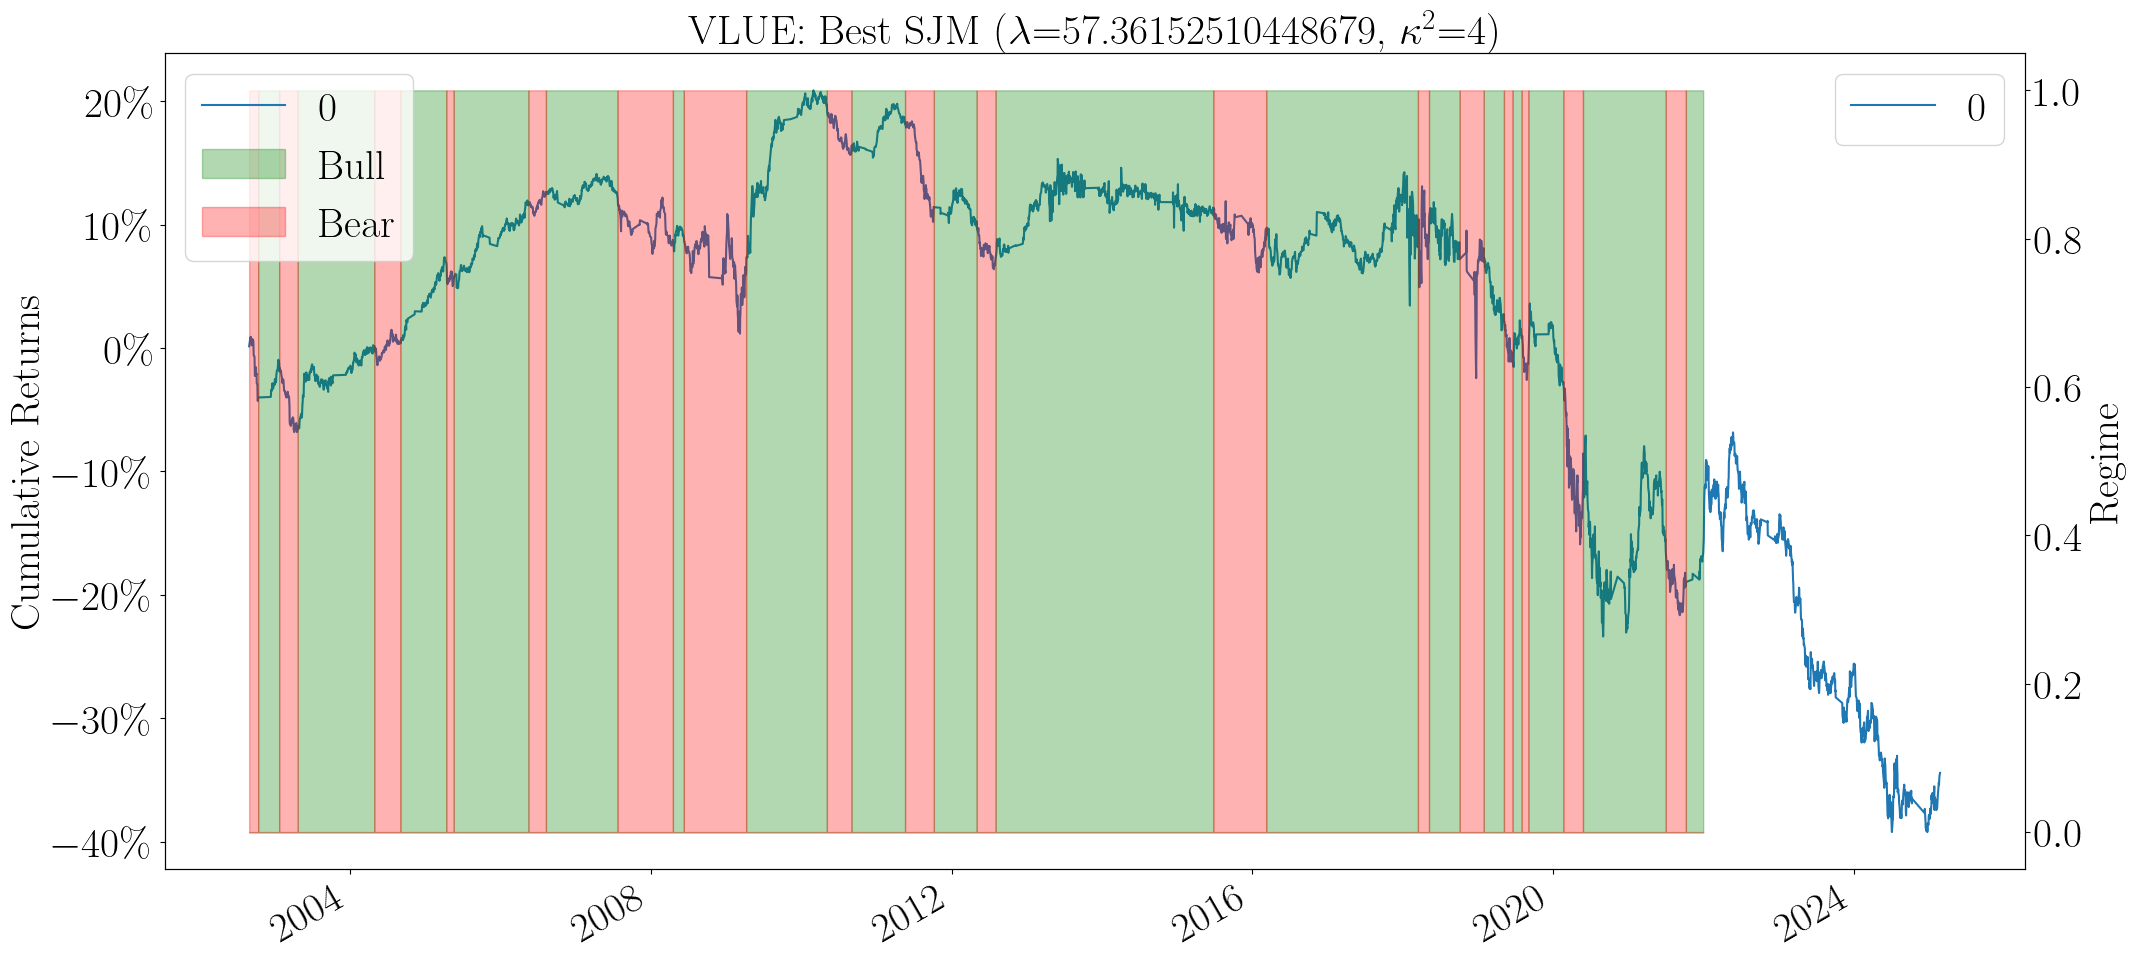


All factors finished.


In [12]:
# ============ 3) Main Script ============

if __name__ == "__main__":
    directory = r"C:\Users\victo\0_thesis_repo\thesis_vri_vp\data"
    factor_file = os.path.join(directory, "factor_data.csv")
    market_file = os.path.join(directory, "market_data.csv")

    # We'll run for these factors:
    all_factors = ["IWF", "MTUM", "QUAL", "SIZE", "USMV", "VLUE"]

    for factor_name in all_factors:
        print("\n==============================================================")
        print(f"Running SJM cross-validation for factor = {factor_name}")
        print("==============================================================")

        # 1) Load data
        data = MergedDataLoader(
            factor_file=factor_file,
            market_file=market_file,
            ver="v2",
            factor_col=factor_name
        ).load(start_date="2002-05-31", end_date="2025-02-24")

        # Ensure alignment
        common_index = data.X.index.intersection(data.ret_ser.index).intersection(data.market_ser.index)
        data.X = data.X.loc[common_index]
        data.ret_ser = data.ret_ser.loc[common_index]
        data.market_ser = data.market_ser.loc[common_index]

        # Drop zero-return dates
        zero_return_dates = data.ret_ser[data.ret_ser == 0.0].index
        data.X = data.X.drop(zero_return_dates, errors='ignore')
        data.ret_ser = data.ret_ser.drop(zero_return_dates, errors='ignore')
        data.market_ser = data.market_ser.drop(zero_return_dates, errors='ignore')

        # 2) Train/test split
        train_start, test_start = "2002-05-31", "2022-01-01"
        X_train = filter_date_range(data.X, start_date=train_start, end_date=test_start)
        X_test  = filter_date_range(data.X, start_date=test_start)

        # For reference
        tr_start_idx, tr_end_idx = X_train.index[[0, -1]]
        print("Training starts:", tr_start_idx, "ends:", tr_end_idx)
        if len(X_test) > 0:
            te_start_idx, te_end_idx = X_test.index[[0, -1]]
            print("Testing starts:", te_start_idx, "ends:", te_end_idx)
        else:
            print("No test data after:", test_start)

        # 3) Preprocessing for final model
        clipper = DataClipperStd(mul=3.)
        scalar_pd = StandardScalerPD()
        X_train_processed = scalar_pd.fit_transform(clipper.fit_transform(X_train))
        if len(X_test) > 0:
            X_test_processed  = scalar_pd.transform(clipper.transform(X_test))
        else:
            X_test_processed = None

        # 4) Define hyperparameter grids
        lambda_values = np.logspace(1.2, 3, 30)  # 0.1 -> 1000
        kappa_values  = np.linspace(2, np.sqrt(X_train.shape[1]), 5)

        # 5) Parallel cross-validation
        from joblib import Parallel, delayed
        market_ser = data.market_ser
        results = Parallel(n_jobs=4)(
            delayed(rolling_time_series_cv_sjm_long_short)(
                lam, kappa, 
                X_train,
                factor_returns=data.ret_ser,
                market_returns=market_ser
            )
            for lam in lambda_values
            for kappa in kappa_values
        )

        # 6) Identify best param
        results_array = np.array(results).reshape(len(lambda_values), len(kappa_values))
        best_index = np.argmax(results)
        best_lambda = lambda_values[best_index // len(kappa_values)]
        best_kappa  = kappa_values[best_index % len(kappa_values)]
        max_feats_best = int(best_kappa**2)
        best_sharpe = results[best_index]

        print(f"[{factor_name}] Best Jump Penalty (λ): {best_lambda}")
        print(f"[{factor_name}] Best Max Features (κ²): {max_feats_best}")
        print(f"[{factor_name}] Sharpe with best hyperparams: {best_sharpe}")

        # 7) Plot Sharpe vs. Lambda for each kappa
        plt.figure()
        for i, kp in enumerate(kappa_values):
            plt.plot(lambda_values, results_array[:, i], label=f"kappa={kp:.2f}")
        plt.xscale('log')
        plt.xlabel('Lambda')
        plt.ylabel('Sharpe')
        plt.title(f"{factor_name}: Sharpe vs. Lambda (Grid CV)")
        plt.legend()
        plt.show()

        # 8) Fit final model on entire training set, predict states, plot in-sample regimes
        final_model = SparseJumpModel(
            n_components=2,
            max_feats=max_feats_best,
            jump_penalty=best_lambda,
            cont=False,
            max_iter=30
        )
        final_model.fit(X_train_processed, data.active_ret, sort_by="cumret")
        predicted_states = final_model.predict(X_train_processed)

        ax, ax2 = plot_regimes_and_cumret(predicted_states, data.active_ret)
        ax.set(title=f"{factor_name}: Best SJM ($\\lambda$={best_lambda}, $\\kappa^2$={max_feats_best})")
        plt.show()

    print("\nAll factors finished.")

In [13]:
# cd C:\Users\victo\0_thesis_repo\thesis_vri_vp\victor
# py -m jupyter nbconvert --to script sjm.ipynb